# DSC 180A Paper Replication
### Microbial Diversity in Clinical Microbiome Studies: Sample Size and Statistical Power Considerations
## Setup

In [1]:
import sys
print(sys.executable)
import rpy2.robjects as ro
from rpy2.robjects.packages import isinstalled

import os

os.environ["PATH"] = "/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/bin:" + os.environ["PATH"]

# Force R (used by rpy2) to look in the env's R library
ro.r('.libPaths("/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/lib/R/library")')

print("R libPaths now:")
print(ro.r(".libPaths()"))
print("phyloseq installed?", isinstalled("phyloseq"))

/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/bin/python
R libPaths now:
[1] "/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/lib/R/library"
[2] "/opt/conda/lib/R/library"                                     

phyloseq installed? True


## Imports

In [2]:
import pandas as pd
import qiime2 as q2
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.power import tt_ind_solve_power
from statistics import mean, stdev
from skbio import DistanceMatrix
from qiime2.plugins import fragment_insertion, diversity
from qiime2 import Metadata, Artifact
from qiime2.plugins.feature_table.methods import rarefy
from skbio import TreeNode
from skbio.diversity.alpha import faith_pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

/home/k5zhao/.conda/envs/qiime2-amplicon-2025.7/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Data Preprocessing

In [3]:
ft = Artifact.load('78873_feature-table.qza')
ft.view(pd.DataFrame)

,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACC,ACGTAGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTTAAGTCAGGAGTGAAAGGCTACGGCTCAACC,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGACGGGCAAGTCTGAAGTGAAAGGCAGGGGCTCAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACG,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTTAACC,ACGTATGTCACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACT,...,ACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGTCAGCAAGTCCGTTGTTAAATCTACCGGCTCAACC,ATGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGAGTAGGCGGGATTACAAGTCTGATGTGAAATACCGAGGCTTAACT,ACATAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGCGTGCAGCCGGGCCGGCAAGTCAGATGTGAAATCTGGAGGCTTAACC,ATGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGTGCGTAGGCGGCGGATTAAGTCCGGAGTAAAATTGTGGGGCTCAACC,ACATAGGGGGCGAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGCGTAGGCGGCATCGTAAGTCTGTTGTGAAAGGCGATGGCTTAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGTAGATCAAGTCGCATGTGAAATACCCGGGCTCAACC,ATGTAGGGGGCGAGCGTTATCCGGAATCATTGGGCGTAAAGAGCGCGTAGGCGGCCCCTCAAGCGGGATCTCTAATCCGAGGGCTCAACC,AGGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGAGTAGGCGGCACGGCAAGTAAGATGTGAAAGCCCACGGCTTAACT,ACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTATGCCGTCTTCTGCTTGAAAAAAGAAAATTTGCGGCTCAACC,ACCTAGGTCCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACC
1629.SubjectIBD026,46430.0,18924.0,6645.0,5276.0,4450.0,2324.0,1322.0,1279.0,1043.0,915.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD414,0.0,41.0,0.0,82.0,0.0,0.0,0.0,1429.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD244,1551.0,1089.0,0.0,3248.0,0.0,4385.0,0.0,15048.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD198,0.0,8573.0,0.0,21.0,0.0,0.0,0.0,271.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629.SubjectIBD222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD195,0.0,779.0,78.0,0.0,0.0,0.0,0.0,2234.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD472,0.0,267.0,653.0,0.0,0.0,0.0,0.0,3999.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD040,0.0,18.0,0.0,0.0,0.0,0.0,0.0,1485.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0


In [6]:
rarefied = rarefy(table=ft, sampling_depth=10000).rarefied_table
# rarefied.save('rarefied_table.qza')
rarefied_df = rarefied.view(pd.DataFrame)
rarefied_df.head()

,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACC,ACGTAGGGGGCTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGCGGTCTTTTAAGTCAGGAGTGAAAGGCTACGGCTCAACC,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGACGGGCAAGTCTGAAGTGAAAGGCAGGGGCTCAACC,ACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGATAGGTCAGTCTGTCTTAAAAGTTCGGGGCTTAACC,ACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACG,ACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTTAACC,ACGTATGTCACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCAGGGCTCAACT,...,ACGGAGGATCCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTTTGATAAGTTAGAGGTGAATACCGGGGCTCAACTC,ACGGAGGATCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACC,ACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTCTTAAGTCTGATGTGAAAACCCCCGGCTCAACC,ATGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGTGAGACAAGTCTGAAGTGAAAATCCGGGGCTTAACC,ACATAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGTGTAGGCGGTTATGTAAGATAGCGGTGAAATCCCGGGGCTTAACC,ACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGTCAGCAAGTCCGTTGTTAAATCTACCGGCTCAACC,ACATAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGCGTGCAGCCGGGCCGGCAAGTCAGATGTGAAATCTGGAGGCTTAACC,ATGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGTGCGTAGGCGGCGGATTAAGTCCGGAGTAAAATTGTGGGGCTCAACC,ACATAGGGGGCGAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGCGTAGGCGGCATCGTAAGTCTGTTGTGAAAGGCGATGGCTTAACC,ACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGTAGATCAAGTCGCATGTGAAATACCCGGGCTCAACC
1629.SubjectIBD026,5066.0,2064.0,731.0,597.0,481.0,282.0,141.0,144.0,119.0,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD414,0.0,1.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD244,138.0,95.0,0.0,287.0,0.0,332.0,0.0,1195.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD198,0.0,487.0,0.0,3.0,0.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1629.SubjectIBD391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,490.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
rooted_tree = q2.Artifact.load('2024.09.phylogeny.asv.nwk.qza')

faith_res = diversity.actions.alpha_phylogenetic(
    table=rarefied,
    phylogeny=rooted_tree,
    metric='faith_pd'
)
faith_pd = faith_res.alpha_diversity.view(pd.Series)
faith_pd

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

faithpd -i /tmp/qiime2/k5zhao/processes/79357-1762211301.22@k5zhao/tmp/q2-OutPath-_1mzt93g -t /tmp/qiime2/k5zhao/data/38091f48-1304-4212-bd7d-079de00525d6/data/tree.nwk -o /tmp/qiime2/k5zhao/processes/79357-1762211301.22@k5zhao/tmp/q2-OutPath-dgevc4a0



1629.SubjectIBD026     4368.699306
1629.SubjectIBD414     4390.909361
1629.SubjectIBD244     5524.096501
1629.SubjectIBD198     6738.374632
1629.SubjectIBD391     8991.554773
                          ...     
1629.SubjectIBD222     5565.601016
1629.SubjectIBD195    11363.426540
1629.SubjectIBD472     7391.131944
1629.SubjectIBD040     9599.950083
1629.SubjectIBD249     2510.583118
Name: faith_pd, Length: 611, dtype: float64

In [8]:
unifrac_res = diversity.actions.beta_phylogenetic(
    table=rarefied,
    phylogeny=rooted_tree,
    metric='unweighted_unifrac'
)
unifrac_dm = unifrac_res.distance_matrix.view(DistanceMatrix)
unifrac_df = pd.DataFrame(unifrac_dm.data, index=unifrac_dm.ids, columns=unifrac_dm.ids)
unifrac_df

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /tmp/qiime2/k5zhao/data/dc1d5a32-404e-4fc5-be0c-fd058fff12a9/data/feature-table.biom -t /tmp/qiime2/k5zhao/data/38091f48-1304-4212-bd7d-079de00525d6/data/tree.nwk -m unweighted -o /tmp/qiime2/k5zhao/processes/79357-1762211301.22@k5zhao/tmp/q2-OutPath-0u74hq77



,1629.SubjectIBD026,1629.SubjectIBD414,1629.SubjectIBD244,1629.SubjectIBD198,1629.SubjectIBD391,1629.SubjectIBD105,1629.SubjectIBD537,1629.SubjectIBD489,1629.SubjectIBD367,1629.SubjectIBD069,...,1629.SubjectIBD108,1629.SubjectIBD551,1629.SubjectIBD163,1629.SubjectIBD484,1629.SubjectIBD419,1629.SubjectIBD222,1629.SubjectIBD195,1629.SubjectIBD472,1629.SubjectIBD040,1629.SubjectIBD249
1629.SubjectIBD026,0.000000,0.711690,0.663577,0.687030,0.720464,0.671357,0.688999,0.683780,0.642012,0.687995,...,0.577783,0.551141,0.607428,0.714749,0.697705,0.717338,0.733561,0.699580,0.743816,0.651385
1629.SubjectIBD414,0.711690,0.000000,0.630855,0.594776,0.679301,0.582901,0.663389,0.639618,0.459071,0.549503,...,0.622545,0.678870,0.567139,0.653982,0.587242,0.555678,0.763070,0.558648,0.656178,0.674941
1629.SubjectIBD244,0.663577,0.630855,0.000000,0.689279,0.641410,0.592155,0.659789,0.600110,0.673577,0.658118,...,0.561494,0.686094,0.619238,0.712420,0.606904,0.695893,0.739314,0.624849,0.656860,0.667133
1629.SubjectIBD198,0.687030,0.594776,0.689279,0.000000,0.578606,0.541405,0.561936,0.516157,0.624504,0.520170,...,0.617462,0.684561,0.680523,0.558105,0.566276,0.587114,0.557351,0.555453,0.578933,0.755898
1629.SubjectIBD391,0.720464,0.679301,0.641410,0.578606,0.000000,0.622805,0.479149,0.505579,0.733078,0.567221,...,0.574381,0.733501,0.728148,0.538411,0.613665,0.589894,0.584513,0.549220,0.523227,0.788856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629.SubjectIBD222,0.717338,0.555678,0.695893,0.587114,0.589894,0.611096,0.649918,0.634202,0.624812,0.549160,...,0.627160,0.709460,0.638700,0.624281,0.624941,0.000000,0.696361,0.573091,0.566603,0.750418
1629.SubjectIBD195,0.733561,0.763070,0.739314,0.557351,0.584513,0.685733,0.596018,0.576178,0.774832,0.627537,...,0.701741,0.773189,0.794922,0.584827,0.686757,0.696361,0.000000,0.649430,0.594634,0.825797
1629.SubjectIBD472,0.699580,0.558648,0.624849,0.555453,0.549220,0.569250,0.596509,0.564062,0.637201,0.483625,...,0.594983,0.695953,0.656819,0.602546,0.525067,0.573091,0.649430,0.000000,0.541925,0.737960
1629.SubjectIBD040,0.743816,0.656178,0.656860,0.578933,0.523227,0.628501,0.533157,0.532919,0.713683,0.526325,...,0.625910,0.753312,0.727521,0.537978,0.620099,0.566603,0.594634,0.541925,0.000000,0.760505


In [9]:
# faith_res.alpha_diversity.save('alpha_diversity.qza')
# unifrac_res.distance_matrix.save('distance_matrix.qza')

## Processing data

In [24]:
metadata = pd.read_csv('metadata.txt', sep='\\t', dtype=str, index_col=0, engine='python')

metadata['deblur alpha diversity'] = faith_pd
metadata.dropna(subset=['deblur alpha diversity'], inplace=True)

b1 = metadata[metadata['cd_behavior'] == 'Non-stricturing, non-penetrating (B1)']
bother = metadata[(metadata['cd_behavior'] != 'Non-stricturing, non-penetrating (B1)') & 
                  (metadata['cd_behavior'] != 'not applicable')]

b1_dtx = unifrac_dm.filter(ids=b1.index).to_series().values
bother_dtx = unifrac_dm.filter(ids=bother.index).to_series().values

In [40]:
# alpha
sd1 = b1['deblur alpha diversity'].std()
sd2 = bother['deblur alpha diversity'].std()
sd12 = mean([sd1, sd2])

#since we used a different tree, our alpha diversity values are scaled by about this value
#faith's pd = sum of branch lengths 
#Faith’s PD: reflects the absolute size/scale of the tree, so the PD values are way larger.
#UniFrac: uses ratios of branch lengths, so it's mostly unaffected by that global scale difference
scale = 4.5e2

base_diffs = [2, 3, 4]                     
scaled_diffs = [d * scale for d in base_diffs]

alpha = 0.05
data_alpha = []
for observations in range(10, 155, 5):
    for difference in scaled_diffs:
        effect_size = difference/sd12
        x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
                               alpha=alpha, ratio=1.0,
                               alternative='two-sided')
        data_alpha.append({
            'alpha': alpha, 'Power (1-β)': x, 
            'Total sample size (N)': observations * 2, 
            'Difference': '%d (effect size %0.2f)' % (
                difference, effect_size)})
data_alpha = pd.DataFrame(data_alpha) 

# beta
u2u1 = abs(mean(b1_dtx) - mean(bother_dtx))
effect_size = u2u1/mean([stdev(b1_dtx), stdev(bother_dtx)])

data_beta = []
for observations in range(10, 155, 5):
    for alpha in [.001, .01, .05, .1]:
        x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
                               alpha=alpha, ratio=1.0,
                               alternative='two-sided')
        data_beta.append({
            'Significance level (α)': alpha, 'Power (1-β)': x, 
            'Total sample size (N)': observations * 2, 
            'Difference': '%d (effect size %0.2f)' % (
                difference, effect_size)})
data_beta = pd.DataFrame(data_beta) 

In [42]:
print ('Alpha diversity:',
    b1['deblur alpha diversity'].mean(),
    bother['deblur alpha diversity'].mean(),
    
    b1['deblur alpha diversity'].std(),
    bother['deblur alpha diversity'].std())

print ('Beta diversity:',
    mean(b1_dtx),
    mean(bother_dtx),
    
    stdev(b1_dtx),
    stdev(bother_dtx))

Alpha diversity: 5952.397824179932 4142.932422809634 1607.9591752488084 1750.6719894092353
Beta diversity: 0.5776163446973265 0.6250148129056801 0.08818314966704248 0.09097301131052349


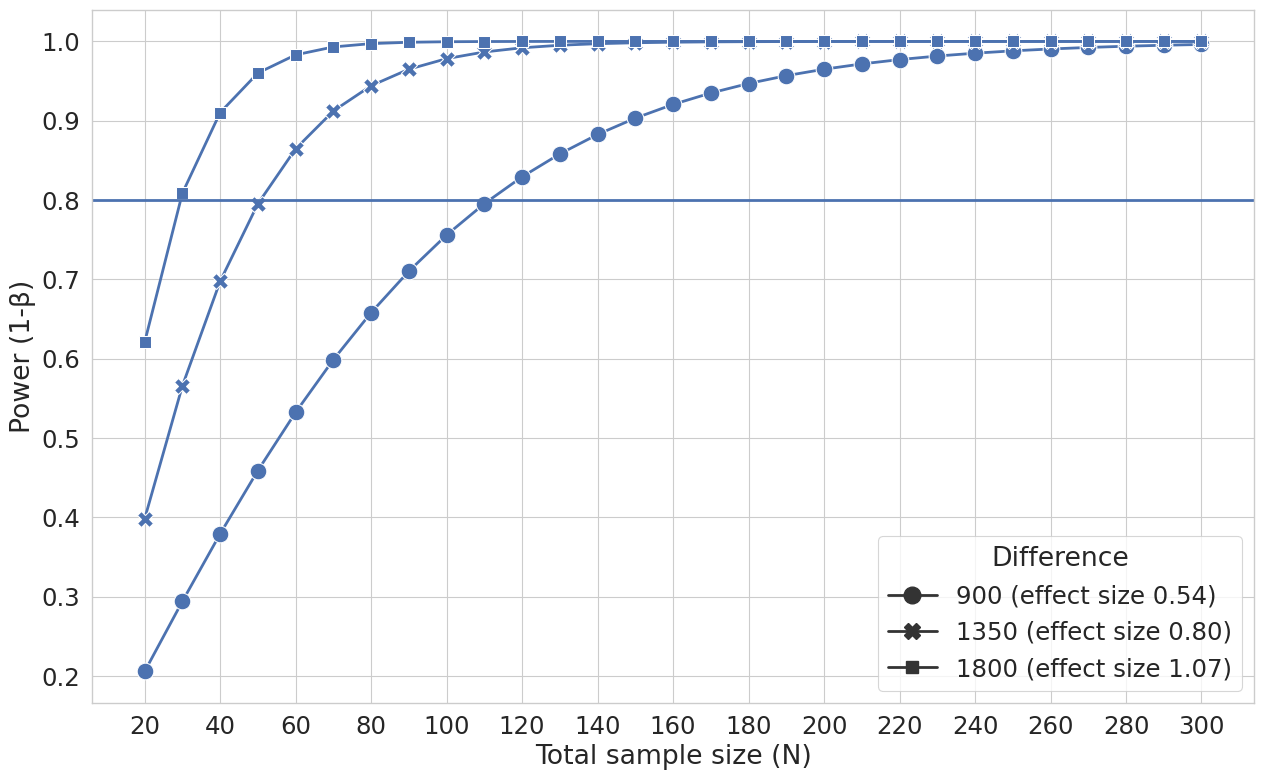

In [43]:
fig, ax1 = plt.subplots(figsize=(15, 9))

sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2, 
                rc={'lines.linewidth': 2, 'lines.markersize': 12})

f = sns.lineplot(x='Total sample size (N)', y='Power (1-β)',
                 markers=True, dashes=False, style='Difference',
                 ax=ax1, data=data_alpha)
ax1.xaxis.set_major_locator(plt.MultipleLocator(20))

plt.axhline(0.8, 0, data_alpha['Total sample size (N)'].max())

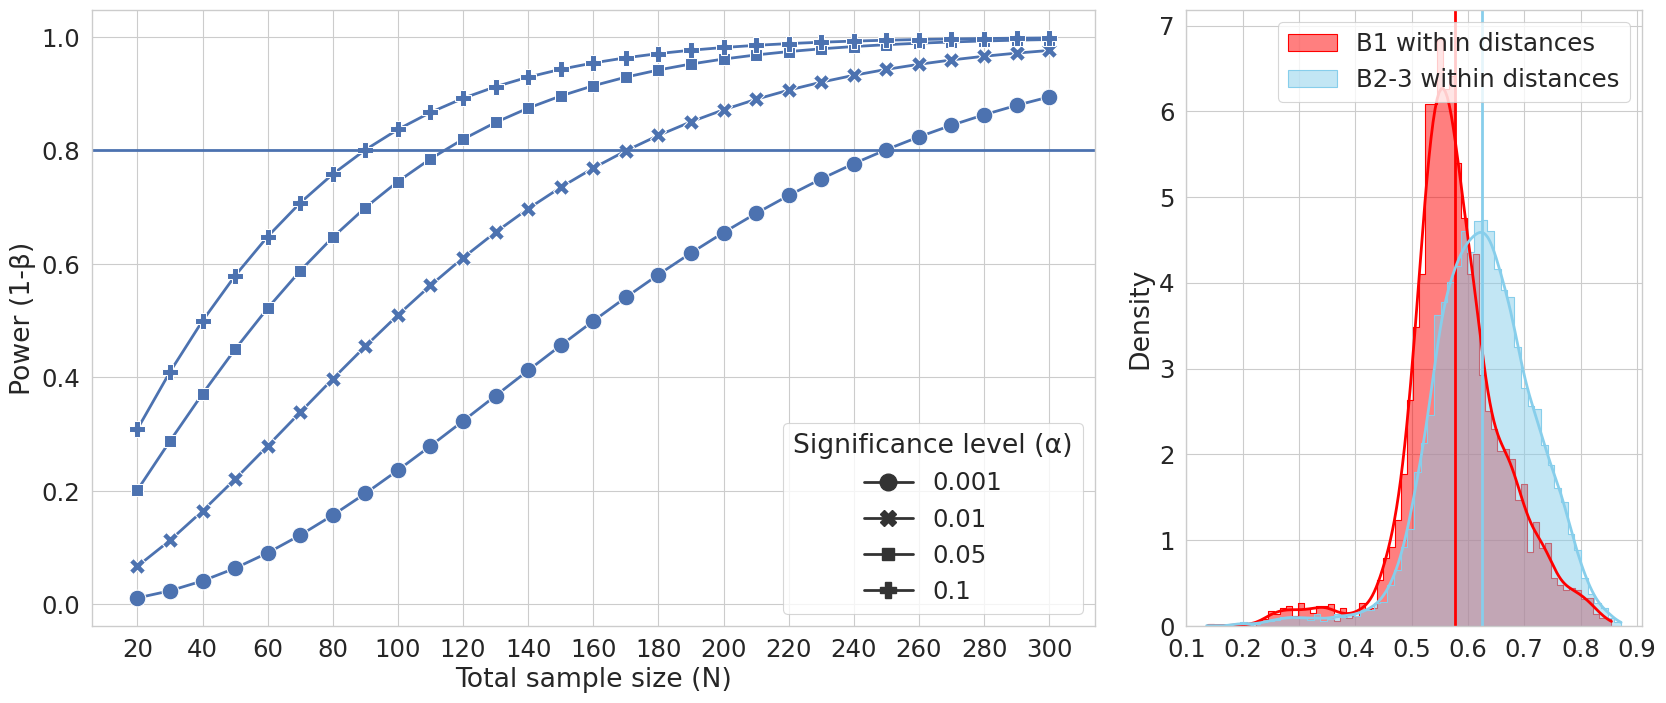

In [46]:
fig = plt.figure(figsize=(20, 8))
grid = plt.GridSpec(ncols=3, nrows=1, hspace=0.2, wspace=0.2)

ax1 = fig.add_subplot(grid[0, :2])
ax2 = fig.add_subplot(grid[0, 2:])

# LEFT: beta power curves (unchanged)
sns.lineplot(x='Total sample size (N)', y='Power (1-β)',
             style='Significance level (α)',
             markers=True, dashes=False,
             ax=ax1, data=data_beta)
ax1.axhline(0.8, 0, data_beta['Total sample size (N)'].max())
ax1.xaxis.set_major_locator(plt.MultipleLocator(20))

# RIGHT: distributions using histplot (+ KDE) instead of distplot
sns.histplot(b1_dtx,
             label="B1 within distances",
             color="red",
             kde=True,
             stat="density",
             element="step",
             ax=ax2)

ax2.axvline(mean(b1_dtx), 0, 6, color="red")

sns.histplot(bother_dtx,
             label="B2-3 within distances",
             color="skyblue",
             kde=True,
             stat="density",
             element="step",
             ax=ax2)

ax2.axvline(mean(bother_dtx), 0, 6, color="skyblue")

ax2.xaxis.set_major_locator(plt.MultipleLocator(.1))
ax2.legend()
